In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import dataloader
from utils.preprocessing import Vectorizer
from utils.preprocessing import Vectorizer_sys

from keras import regularizers
from keras.models import  Model
from keras.layers import Dense, Input, BatchNormalization
from keras.callbacks import EarlyStopping

In [2]:
'''
HDFS
'''

train_ratio = 0.8
window_size = 10

struct_log = '../data/HDFS_100k.log_structured.csv' # The structured log file
label_file = '../data/HDFS_100k.log_anomaly_label.csv' # The anomaly label file

df = pd.read_csv(struct_log)

(x_train, window_y_train, y_train), (x_test, window_y_test, y_test) = \
dataloader.load_HDFS(struct_log, label_file=label_file, window='session',
                      window_size=window_size, train_ratio=train_ratio, split_type='uniform')

feature_extractor = Vectorizer()
train_dataset = feature_extractor.fit_transform(x_train, window_y_train, y_train)
test_dataset = feature_extractor.transform(x_test, window_y_test, y_test)


if train_dataset['x'].max() == test_dataset['x'].max():
    train_dataset['x'] = train_dataset['x']/train_dataset['x'].max()
    test_dataset['x'] = test_dataset['x']/test_dataset['x'].max()

else:
    raise 'Little probelm happen'

====== Input data summary ======
Loading ../data/HDFS_100k.log_structured.csv
250 63
Slicing 6351 sessions, with window 10
Slicing done, 27805 windows generated
Slicing 1589 sessions, with window 10
Slicing done, 6408 windows generated
Train: 27805 windows (1053/27805 anomaly), 26752/27805 normal
Test: 6408 windows (253/6408 anomaly), 6155/6408 normal


In [3]:
# Autoencoder model.
input_dim = train_dataset['x'].shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(input_dim//3*2, activation='relu',kernel_regularizer=regularizers.l2(0.01))(input)
encode = BatchNormalization()(encode)
encode = Dense(input_dim//3, activation='relu',kernel_regularizer=regularizers.l2(0.01))(encode)
encode = BatchNormalization()(encode)
encode = Dense(1, activation='relu',kernel_regularizer=regularizers.l2(0.01))(encode)
encode = BatchNormalization()(encode)

decode = Dense(input_dim//3, activation='relu')(encode)
decode = BatchNormalization()(decode)
decode = Dense(input_dim//3*2, activation='relu')(decode)
decode = BatchNormalization()(decode)
decode = Dense(input_dim, activation='sigmoid')(decode)

autoencoder = Model(input, decode)
early_stopping = EarlyStopping(monitor='loss', mode='min')
autoencoder.compile(optimizer='adam',
        loss='mse',
        metrics=['accuracy'])


# Train model.
history = autoencoder.fit(train_dataset['x'], train_dataset['x'],
                        epochs=100,
                        batch_size=128,
                        shuffle=True,
                        callbacks = [early_stopping]
                        )

Epoch 1/100
218/218 [==============================] - 19s 20ms/step - loss: 0.1707 - accuracy: 0.0340
Epoch 2/100
218/218 [==============================] - 4s 20ms/step - loss: 0.0759 - accuracy: 0.4271
Epoch 3/100
218/218 [==============================] - 4s 20ms/step - loss: 0.0385 - accuracy: 0.4855
Epoch 4/100
218/218 [==============================] - 4s 20ms/step - loss: 0.0241 - accuracy: 0.3018
Epoch 5/100
218/218 [==============================] - 4s 20ms/step - loss: 0.0178 - accuracy: 0.3538
Epoch 6/100
218/218 [==============================] - 4s 20ms/step - loss: 0.0121 - accuracy: 0.3986
Epoch 7/100
218/218 [==============================] - 4s 20ms/step - loss: 0.0113 - accuracy: 0.5557
Epoch 8/100
218/218 [==============================] - 4s 20ms/step - loss: 0.0102 - accuracy: 0.6494
Epoch 9/100
218/218 [==============================] - 4s 20ms/step - loss: 0.0098 - accuracy: 0.6705
Epoch 10/100
218/218 [==============================] - 4s 20ms/step - loss: 0.00

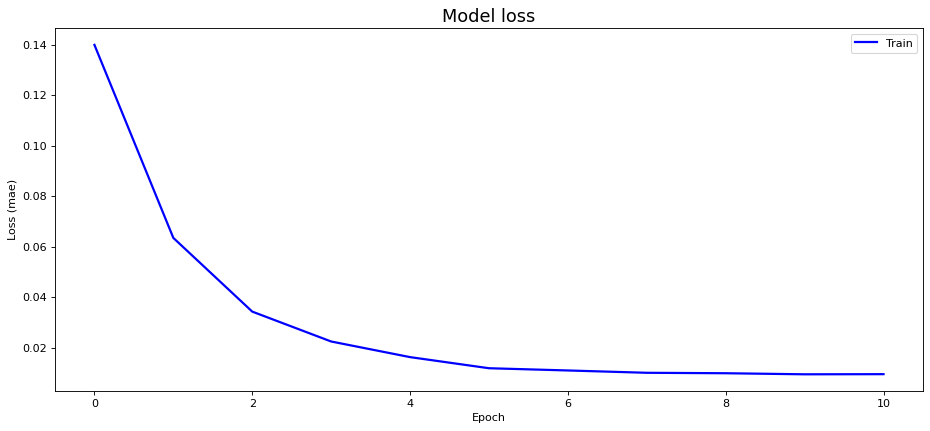

In [4]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

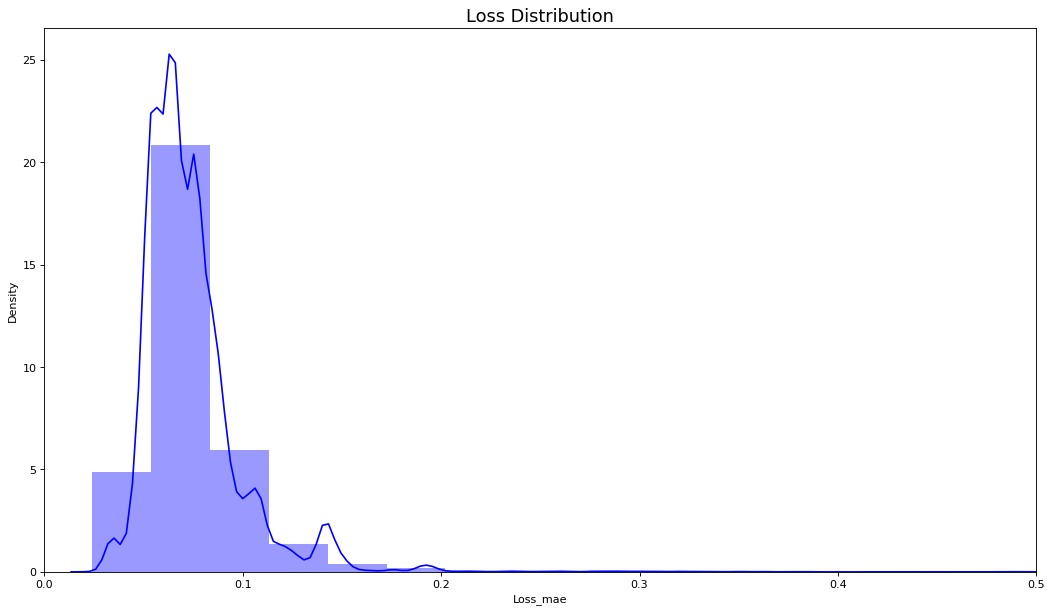

In [5]:
# plot the loss distribution of the training set
X_pred = autoencoder.predict(train_dataset['x'])
X_pred = pd.DataFrame(X_pred)

train_scored = pd.DataFrame()
Xtrain = train_dataset['x']
train_scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(train_scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [6]:
train_scored.quantile(0.9)

Loss_mae    0.101645
Name: 0.9, dtype: float64

In [7]:
# calculate the loss on the test set
X_pred = autoencoder.predict(test_dataset['x'])
X_pred = pd.DataFrame(X_pred)

scored = pd.DataFrame()
Xtest = test_dataset['x']
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] =  train_scored.quantile(0.9)[0]
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
0,0.097919,0.101645,False
1,0.110848,0.101645,True
2,0.101415,0.101645,False
3,0.107728,0.101645,True
4,0.078562,0.101645,False


In [8]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = autoencoder.predict(train_dataset['x'])
X_pred_train = pd.DataFrame(X_pred_train)

scored_train = pd.DataFrame()
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = train_scored.quantile(0.9)[0]
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

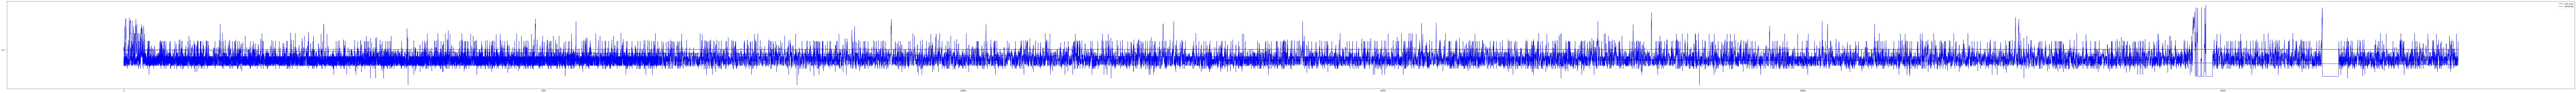

In [9]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(256,9), color=['blue','red'])

In [10]:
scored['Anomaly']

0       False
1       False
2       False
3       False
4       False
        ...  
6403    False
6404    False
6405    False
6406    False
6407    False
Name: Anomaly, Length: 34213, dtype: bool

In [11]:
ture_ = pd.Series(train_dataset['y']).append(pd.Series(test_dataset['y']))

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [13]:
confusion_matrix(ture_,scored['Anomaly'])

array([[30385,  2522],
       [  917,   389]], dtype=int64)

In [14]:
accuracy_score(ture_,scored['Anomaly'])

0.899482652792798

In [15]:
f1_score(ture_,scored['Anomaly'])

0.1844913445577425